# Goals
- Determine the most valuable subscribers
- Understand subscriber segments
- What subscribers could be sold additional products/services
- Find the subscriber profile of those not continuing with the product
- Find out how to deepen subscriber engagement
- Identify any other opportunities that arise from analysis
## Questions
- Should we standardize purchase ammount, or recalculate based on the date data
- Due to some columns >50% null, should we do use some sampling techniques 
- Are the ids guaranteed to be unique 
## Contact Info
tonks@chapman.edu
flath@chapman.edu
jgonzalez@chapman.edu
tsirtsis@chapman.edu
dkeefe@chapman.edu


In [54]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from scipy import stats
import datetime

### Subscriber Data

In [2]:
subscriber = pd.read_csv("data/subscriber.csv")
subscriber.head()

,ID,Language,Subscription Type,Subscription Event Type,Purchase Store,Purchase Amount,Currency,Subscription Start Date,Subscription Expiration,Demo User,...,Country,User Type,Lead Platform,Email Subscriber,Push Notifications,Send Count,Open Count,Click Count,Unique Open Count,Unique Click Count
0,1,POR,Limited,INITIAL_PURCHASE,App,NaN,NaN,12/28/2018,6/28/2019,Yes,...,US/Canada,Consumer,App,Yes,Yes,63.0,7.0,0.0,6.0,0.0
1,2,EBR,Limited,INITIAL_PURCHASE,Web,39.0,USD,11/28/2019,2/28/2020,No,...,Other,Consumer,Web,No,Yes,4.0,3.0,0.0,1.0,0.0
2,3,ESP,Limited,INITIAL_PURCHASE,Web,0.0,USD,12/31/2018,12/31/2019,No,...,US/Canada,Consumer,Web,Yes,Yes,1.0,0.0,0.0,0.0,0.0
3,4,KOR,Limited,INITIAL_PURCHASE,App,NaN,NaN,11/7/2019,2/7/2020,Yes,...,US/Canada,Consumer,App,Yes,Yes,14.0,0.0,0.0,0.0,0.0
4,5,ENG,Limited,INITIAL_PURCHASE,App,NaN,NaN,8/13/2019,11/13/2019,No,...,US/Canada,Consumer,Web,Yes,Yes,80.0,5.0,1.0,5.0,1.0


In [3]:
subscriber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40102 entries, 0 to 40101
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       40102 non-null  int64  
 1   Language                 40102 non-null  object 
 2   Subscription Type        40102 non-null  object 
 3   Subscription Event Type  40102 non-null  object 
 4   Purchase Store           40102 non-null  object 
 5   Purchase Amount          26923 non-null  float64
 6   Currency                 26924 non-null  object 
 7   Subscription Start Date  40102 non-null  object 
 8   Subscription Expiration  40102 non-null  object 
 9   Demo User                40102 non-null  object 
 10  Free Trial User          40102 non-null  object 
 11  Free Trial Start Date    5833 non-null   object 
 12  Free Trial Expiration    5833 non-null   object 
 13  Auto Renew               40101 non-null  object 
 14  Country               

In [4]:
subscriber.describe()

,ID,Purchase Amount,Send Count,Open Count,Click Count,Unique Open Count,Unique Click Count
count,40102.000000,2.692300e+04,28448.000000,28448.000000,28448.000000,28448.000000,28448.000000
mean,19980.310982,3.270582e+08,32.389307,8.233971,2.154246,3.892435,0.362943
std,11550.985627,1.681253e+10,58.436061,37.385582,29.366507,13.137642,1.132356
min,1.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,9970.250000,0.000000e+00,4.000000,0.000000,0.000000,0.000000,0.000000
50%,19972.500000,3.881000e+01,10.000000,1.000000,0.000000,1.000000,0.000000
75%,29983.750000,1.523900e+02,33.000000,5.000000,0.000000,2.000000,0.000000
max,40000.000000,1.600000e+12,4370.000000,4365.000000,4348.000000,196.000000,44.000000


In [5]:
subscriber.isna().sum()

ID                             0
Language                       0
Subscription Type              0
Subscription Event Type        0
Purchase Store                 0
Purchase Amount            13179
Currency                   13178
Subscription Start Date        0
Subscription Expiration        0
Demo User                      0
Free Trial User                0
Free Trial Start Date      34269
Free Trial Expiration      34269
Auto Renew                     1
Country                        0
User Type                      0
Lead Platform                  0
Email Subscriber               0
Push Notifications             0
Send Count                 11654
Open Count                 11654
Click Count                11654
Unique Open Count          11654
Unique Click Count         11654
dtype: int64

> Thre currency column is not standardized and will greatly affect models if it is not set to one currency, we need to set all values in curency to USD. Currency exchange rates were taken from [here](https://www.x-rates.com/table/?from=USD&amount=1).

In [6]:
subscriber['Currency'].unique()

array([nan, 'USD', 'GBP', 'PLN', 'EUR', 'BRL', 'KRW', 'MXN', 'UAH', 'RUB',
       'CHF', 'CAD', 'CZK', 'RON', 'AUD', 'THB', 'JPY', 'INR', 'COP',
       'BGN', 'ZAR', 'HUF', 'SAR', 'TRY', 'SGD', 'VND', 'RSD', 'ILS',
       'SEK', 'PHP', 'NOK', 'EGP', 'QAR', 'IDR', 'PEN', 'AED', 'LBP',
       'KZT', 'GHS', 'HKD', 'CLP', 'CRC', 'NZD', 'DKK', 'MYR'],
      dtype=object)

In [7]:
usd_convert = {'USD' : 1,
               'GBP' : 1.39,
               'PLN' : 0.26,
               'EUR' : 1.21,
               'BRL' : 0.18,
               'KRW' : 0.0009,
               'MXN' : 0.5,
               'UAH' : 0.36,
               'RUB' : 0.13,
               'CHF' : 1.09,
               'CAD' : 0.81,
               'CZK' : 0.47,
               'RON' : 0.25,
               'AUD' : 0.78,
               'THB' : 0.32,
               'JPY' : 0.0092,
               'INR' : 0.013,
               'COP' : 0.00028,
               'BGN' : 0.62,
               'ZAR' : 0.7,
               'HUF' : 0.0033,
               'SAR' : 0.27,
               'TRY' : 0.12,
               'SGD' : 0.75,
               'VND' : 0.000043,
               'RSD' : 0.01,
               'ILS' : 0.31,
               'SEK' : 0.12,
               'PHP' : 0.021,
               'NOK' : 0.12,
               'EGP' : 0.064,
               'QAR' : 0.27,
               'IDR' : 0.000069,
               'PEN' : 0.26,
               'AED' : 0.27,
               'LBP' : 0.00066,
               'KZT' : 0.0023,
               'GHS' : 0.17,
               'HKD' : 0.13,
               'CLP' : 0.0014,
               'CRC' : 0.0016,
               'NZD' : 0.072,
               'DKK' : 0.16,
               'MYR' : 0.24}

In [8]:
for index in subscriber.index:
    if subscriber.at[index, 'Currency'] is np.nan:
        continue
    elif subscriber.at[index, 'Currency'] != 'USD':
        current_val = subscriber.at[index, 'Purchase Amount']
        new_val = current_val * usd_convert[subscriber.at[index, 'Currency']]
        subscriber.at[index, 'Purchase Amount'] = new_val
        subscriber.at[index, 'Currency'] = 'USD'
    else:
        continue
        
subscriber['Purchase Amount'] = subscriber['Purchase Amount'].apply(lambda x: round(x, 2))
#subscriber.to_csv("data/subscriber_clean.csv")
subscriber.head(20)

,ID,Language,Subscription Type,Subscription Event Type,Purchase Store,Purchase Amount,Currency,Subscription Start Date,Subscription Expiration,Demo User,...,Country,User Type,Lead Platform,Email Subscriber,Push Notifications,Send Count,Open Count,Click Count,Unique Open Count,Unique Click Count
0,1,POR,Limited,INITIAL_PURCHASE,App,NaN,NaN,12/28/2018,6/28/2019,Yes,...,US/Canada,Consumer,App,Yes,Yes,63.0,7.0,0.0,6.0,0.0
1,2,EBR,Limited,INITIAL_PURCHASE,Web,39.00,USD,11/28/2019,2/28/2020,No,...,Other,Consumer,Web,No,Yes,4.0,3.0,0.0,1.0,0.0
2,3,ESP,Limited,INITIAL_PURCHASE,Web,0.00,USD,12/31/2018,12/31/2019,No,...,US/Canada,Consumer,Web,Yes,Yes,1.0,0.0,0.0,0.0,0.0
3,4,KOR,Limited,INITIAL_PURCHASE,App,NaN,NaN,11/7/2019,2/7/2020,Yes,...,US/Canada,Consumer,App,Yes,Yes,14.0,0.0,0.0,0.0,0.0
4,5,ENG,Limited,INITIAL_PURCHASE,App,NaN,NaN,8/13/2019,11/13/2019,No,...,US/Canada,Consumer,Web,Yes,Yes,80.0,5.0,1.0,5.0,1.0
5,6,ESP,Limited,INITIAL_PURCHASE,Web,38.34,USD,8/23/2019,11/23/2019,Yes,...,US/Canada,Consumer,App,Yes,Yes,162.0,1.0,0.0,1.0,0.0
6,7,ESP,Limited,RENEWAL,Web,79.00,USD,7/21/2019,11/11/2019,Yes,...,Other,Consumer,App,Yes,Yes,2.0,0.0,0.0,0.0,0.0
7,8,DEU,Limited,INITIAL_PURCHASE,Web,38.40,USD,3/7/2020,6/7/2020,Yes,...,US/Canada,Consumer,App,Yes,Yes,25.0,17.0,4.0,7.0,2.0
8,9,DEU,Limited,INITIAL_PURCHASE,Web,43.16,USD,3/3/2020,6/8/2020,No,...,Europe,Consumer,Web,No,Yes,52.0,11.0,0.0,5.0,0.0
9,10,ESP,Limited,RENEWAL,App,NaN,NaN,3/21/2020,3/6/2021,No,...,US/Canada,Consumer,App,No,Yes,1.0,0.0,0.0,0.0,0.0


>Purchase amount and currency is standardized to USD, now to take care of outliers

C:\Users\jade5\anaconda3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_boxplot : Removed 13179 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


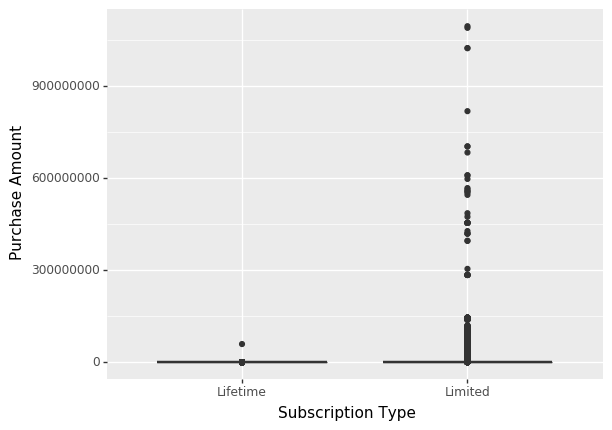

<ggplot: (-9223371913791446032)>

In [9]:
ggplot(subscriber) + geom_boxplot(aes(x = 'Subscription Type' , y = 'Purchase Amount'))

> Very unrealistic purchase amounts appear for mostly Limited subscriptions, dropping those with a purchase amount of above 300 as the max purchase price of a Rosetta Stone service is 299

In [10]:
subscriber.drop(subscriber.loc[subscriber['Purchase Amount'] > 300].index, inplace=True)
subscriber.describe()

,ID,Purchase Amount,Send Count,Open Count,Click Count,Unique Open Count,Unique Click Count
count,38438.000000,25259.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000
mean,20176.260393,69.698572,33.213973,8.439334,2.197511,4.000913,0.369580
std,11551.334791,75.436699,59.239086,37.989768,29.905087,13.327759,1.142726
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,10203.250000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,20261.500000,36.940000,10.000000,1.000000,0.000000,1.000000,0.000000
75%,30209.750000,119.000000,35.000000,6.000000,0.000000,2.000000,0.000000
max,40000.000000,299.000000,4370.000000,4365.000000,4348.000000,196.000000,44.000000


C:\Users\jade5\anaconda3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_boxplot : Removed 13179 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


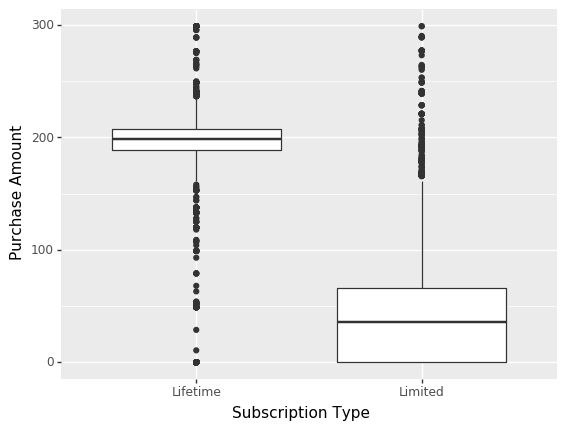

<ggplot: (-9223371913790891584)>

In [11]:
ggplot(subscriber) + geom_boxplot(aes(x = 'Subscription Type' , y = 'Purchase Amount'))

> The distribution is looking much better, still unsure why some purchase amounts are so high given that the most expensive Consumer product on Rosetta Stone is 299

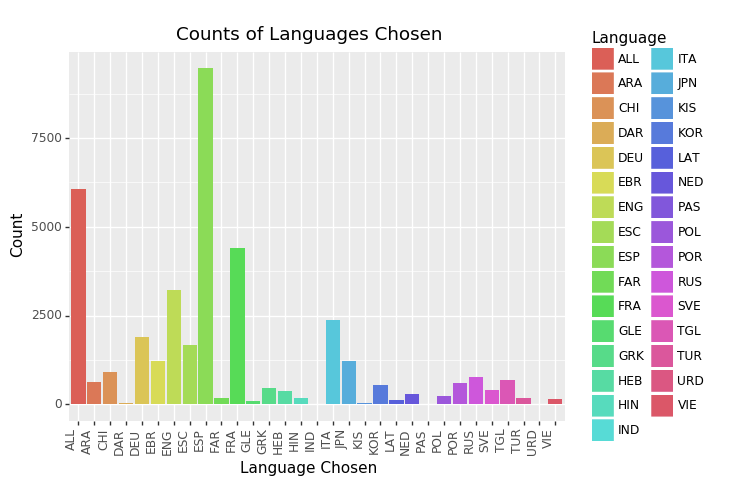

<ggplot: (-9223371913791421876)>

In [12]:
# Comparison of language chosen
ggplot(subscriber, aes(x = 'Language', fill = 'Language')) +  geom_bar() + ylab('Count') + xlab('Language Chosen') +  ggtitle('Counts of Languages Chosen') + theme(axis_text_x=element_text(rotation=90, hjust=1))

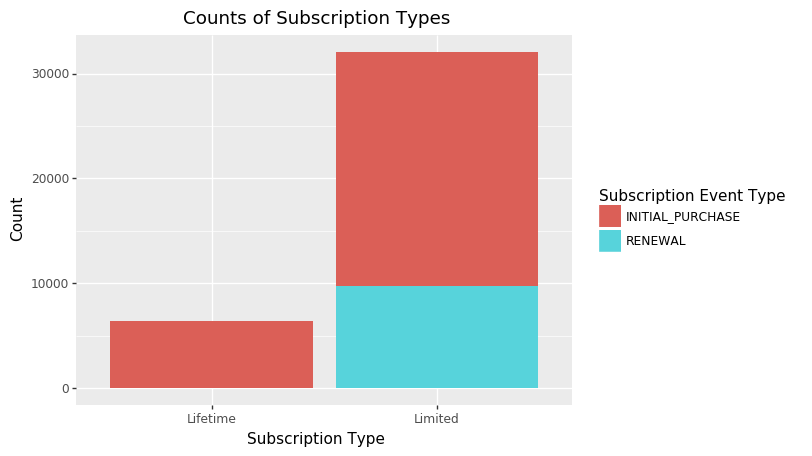

<ggplot: (-9223371913798470348)>

In [13]:
# Type of subscriptions
ggplot(subscriber, aes(x = 'Subscription Type', fill = 'Subscription Event Type')) + geom_bar() + ylab('Count') + xlab('Subscription Type') + ggtitle('Counts of Subscription Types')

> There are very few lifetime subscription purchase compared to limited subscriptions, additionally many subscribers do not renew their subscription (high churn)

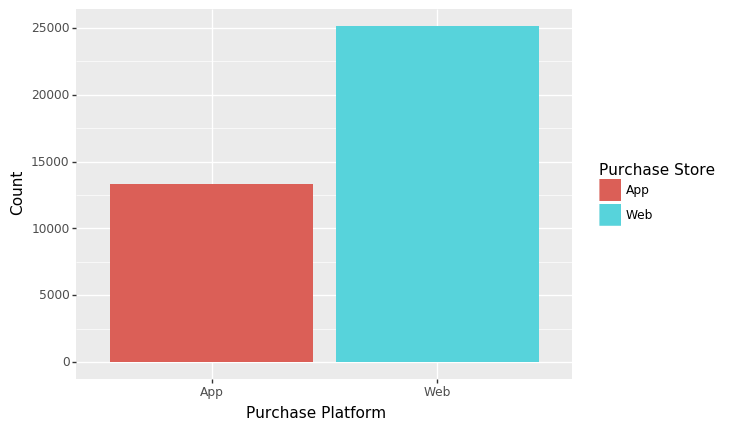

<ggplot: (-9223371913790108096)>

In [14]:
# Purchase platform
ggplot(subscriber, aes(x = 'Purchase Store', fill = 'Purchase Store')) + geom_bar() + ylab('Count') + xlab('Purchase Platform')

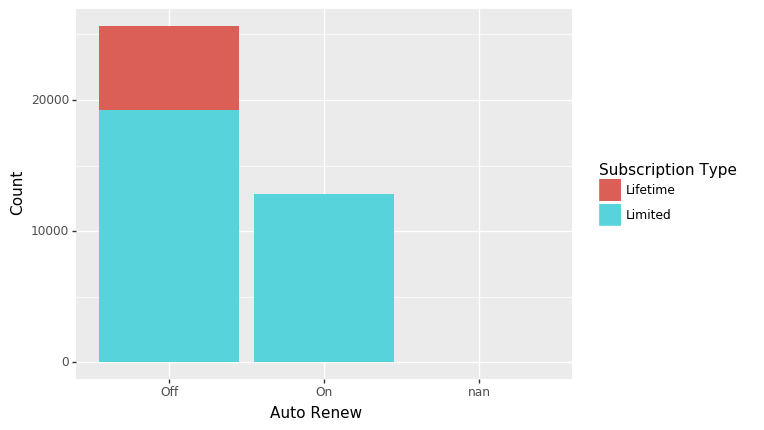

<ggplot: (-9223371913790193496)>

In [15]:
# Auto Renew
# Type of subscriptions
ggplot(subscriber, aes(x = 'Auto Renew', fill = 'Subscription Type')) + geom_bar() + ylab('Count') + xlab('Auto Renew')

> Lifetime subscriptions will not have auto renew on, but more subscribers with a limited subscripsion turn auto renew off

C:\Users\jade5\anaconda3\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 26'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


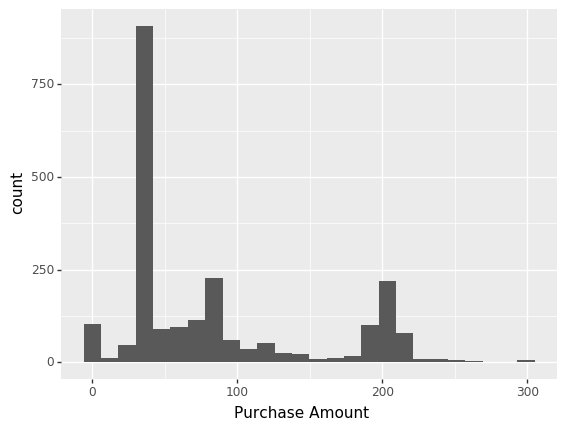

<ggplot: (-9223371913790136100)>

In [16]:
purchase_amount = subscriber
purchase_amount.dropna(inplace = True)
ggplot(purchase_amount, aes(x = 'Purchase Amount')) + geom_histogram()

### App Activity

In [17]:
app_act = pd.read_csv("data/appactivity.csv")
app_act.head()

,ID,App Session Platform,App Activity Type,App Session Date
0,1,ios,App Launch,3/20/2019
1,2,android,App Launch,12/3/2019
2,3,ios,App Launch,5/2/2019
3,4,ios,App Launch,2/6/2020
4,5,ios,Start,9/14/2019


In [18]:
app_act.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809478 entries, 0 to 809477
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   ID                    809478 non-null  int64 
 1   App Session Platform  765300 non-null  object
 2   App Activity Type     795058 non-null  object
 3   App Session Date      795058 non-null  object
dtypes: int64(1), object(3)
memory usage: 24.7+ MB


In [19]:
app_act.isna().sum()

ID                          0
App Session Platform    44178
App Activity Type       14420
App Session Date        14420
dtype: int64

> Null values make up less than 1% of the data so it would be best to just drop these

In [20]:
app_act.dropna(inplace = True)
app_act.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 765300 entries, 0 to 809477
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   ID                    765300 non-null  int64 
 1   App Session Platform  765300 non-null  object
 2   App Activity Type     765300 non-null  object
 3   App Session Date      765300 non-null  object
dtypes: int64(1), object(3)
memory usage: 29.2+ MB


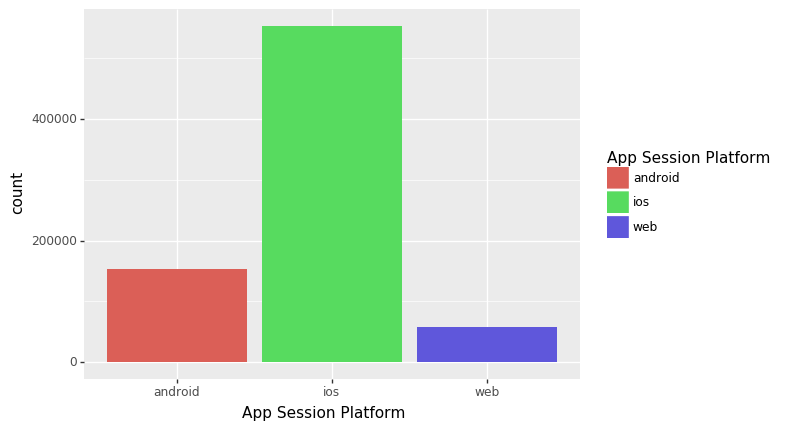

<ggplot: (-9223371913790860240)>

In [21]:
ggplot(app_act, aes(x = 'App Session Platform', fill = 'App Session Platform')) + geom_bar()

> A majority of subscribers are present on Apple platforms

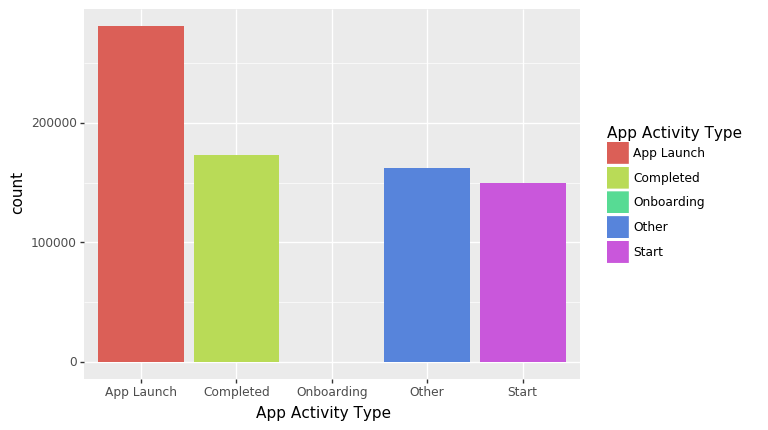

<ggplot: (-9223371913790879004)>

In [22]:
ggplot(app_act, aes(x = 'App Activity Type', fill = 'App Activity Type')) + geom_bar()

### Subscriber Segments
> [source](https://inseaddataanalytics.github.io/INSEADAnalytics/CourseSessions/Sessions45/ClusterAnalysisReading.html)

In [23]:
subscriber.head()

,ID,Language,Subscription Type,Subscription Event Type,Purchase Store,Purchase Amount,Currency,Subscription Start Date,Subscription Expiration,Demo User,...,Country,User Type,Lead Platform,Email Subscriber,Push Notifications,Send Count,Open Count,Click Count,Unique Open Count,Unique Click Count
8,9,DEU,Limited,INITIAL_PURCHASE,Web,43.16,USD,3/3/2020,6/8/2020,No,...,Europe,Consumer,Web,No,Yes,52.0,11.0,0.0,5.0,0.0
11,12,ESP,Limited,INITIAL_PURCHASE,Web,35.97,USD,10/17/2019,1/21/2020,No,...,US/Canada,Consumer,Web,Yes,Yes,94.0,0.0,0.0,0.0,0.0
16,17,ALL,Lifetime,INITIAL_PURCHASE,Web,199.00,USD,3/25/2020,1/1/2099,No,...,US/Canada,Consumer,Web,Yes,Yes,8.0,6.0,3.0,2.0,1.0
41,42,ESP,Limited,INITIAL_PURCHASE,Web,38.89,USD,1/27/2020,4/30/2020,No,...,US/Canada,Consumer,Web,Yes,Yes,19.0,11.0,4.0,7.0,2.0
42,43,RUS,Limited,INITIAL_PURCHASE,Web,39.00,USD,8/22/2019,11/25/2019,No,...,Europe,Consumer,Web,No,Yes,79.0,56.0,1.0,38.0,1.0


In [28]:
subscriber[["Subscription Start Date", "Subscription Expiration"]] = subscriber[["Subscription Start Date", "Subscription Expiration"]].apply(pd.to_datetime)

subscriber["InvoiceDate"] = subscriber["Subscription Start Date"].dt.date
recent_date = max(subscriber.InvoiceDate) + datetime.timedelta(days = 1)
customers = subscriber.groupby(['ID']).agg({
    'InvoiceDate' : lambda x: (recent_date - x.max()).days,
    'Subscription Event Type' : 'count',
    'Purchase Amount' : 'sum'})
customers.rename(columns = {'InvoiceDate' : 'Recency',
                            'Subscription Event Type' : 'Frequency',
                            'Purchase Amount' : 'Monetary Value'}, inplace = True)

In [29]:
customers.head()

,Recency,Frequency,Monetary Value
ID,,,
9,29,1,43.16
12,167,1,35.97
17,7,1,199.00
42,65,1,38.89
43,223,1,39.00


In [39]:
customers_fixed = pd.DataFrame()
customers_fixed["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fixed["Frequency"] = pd.Series(np.log(customers['Frequency'])).values
customers_fixed["MonetaryValue"] = pd.Series(np.cbrt(customers['Monetary Value'])).values

C:\Users\jade5\anaconda3\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 14'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


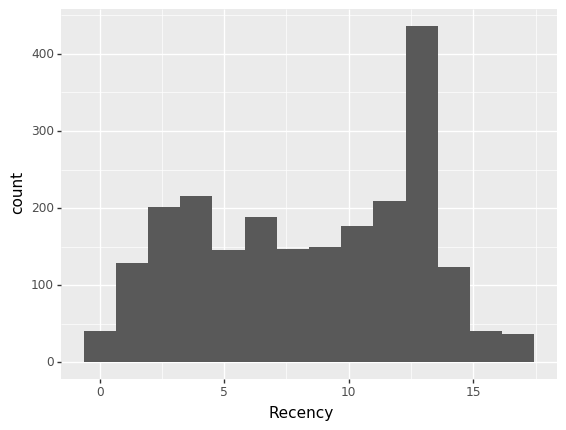

<ggplot: (-9223371913910849760)>

In [40]:
ggplot(customers_fixed, aes(x = 'Recency')) + geom_histogram()

C:\Users\jade5\anaconda3\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 48'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


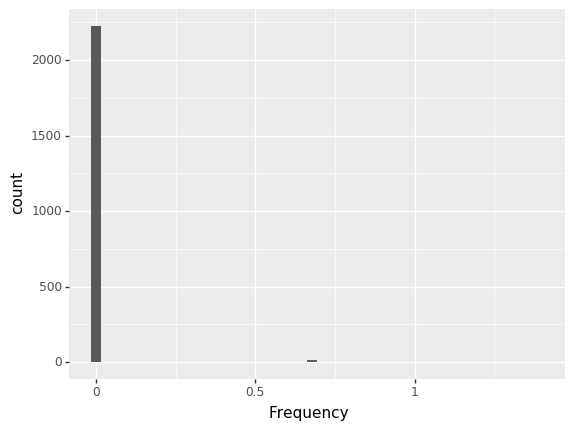

<ggplot: (-9223371913910817656)>

In [41]:
ggplot(customers_fixed, aes(x = 'Frequency')) + geom_histogram()

C:\Users\jade5\anaconda3\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 31'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


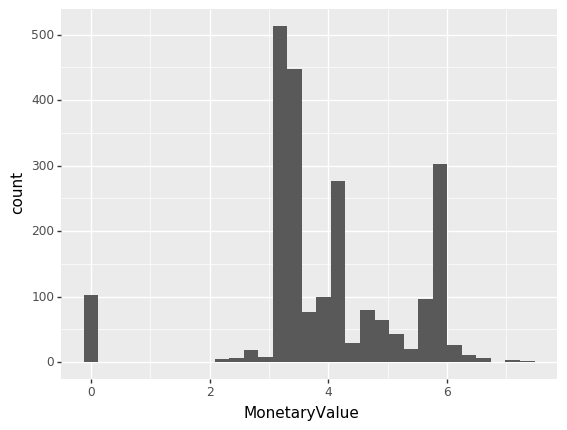

<ggplot: (-9223371913910786076)>

In [42]:
ggplot(customers_fixed, aes(x = 'MonetaryValue')) + geom_histogram()

In [43]:
scaler = StandardScaler()

scaler.fit(customers_fixed)
customers_norm = scaler.transform(customers_fixed)
print(customers_norm.mean(axis = 0).round(2))

[0. 0. 0.]


C:\Users\jade5\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


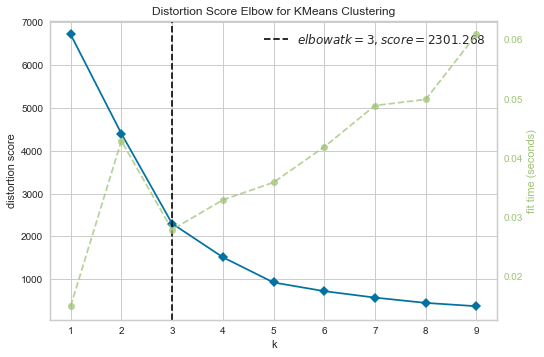

In [44]:
km = KMeans()
visualizer = KElbowVisualizer(km, k=(1,10))
visualizer.fit(customers_norm)
visualizer.show()

In [46]:
kmm = KMeans(n_clusters = 3, random_state = 410)
kmm.fit(customers_norm)
kmm.labels_.shape

(2239,)

In [49]:
customers["Cluster"] = kmm.labels_
customers.groupby('Cluster').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'Monetary Value' : ['mean', 'count']}).round(2)

Recency Frequency Monetary Value      
           mean      mean           mean count
Cluster                                       
0         20.41      1.00         131.10   908
1        207.26      1.00          49.48  1317
2         46.00      2.14         221.05    14

In [52]:
subscribers_norm = pd.DataFrame(customers_norm, columns = ['Recency', 'Frequency', 'Monetary Value'])
subscribers_norm['ID'] = customers.index
subscribers_norm['Cluster'] = kmm.labels_

subscribers_melt = pd.melt(subscribers_norm.reset_index(),
                          id_vars = ['ID', 'Cluster'],
                          value_vars = ['Recency', 'Frequency', 'Monetary Value'],
                          var_name = 'Attribute',
                          value_name = 'Value')
subscribers_melt.head()

,ID,Cluster,Attribute,Value
0,9,0,Recency,-0.662250
1,12,1,Recency,0.614656
2,17,0,Recency,-1.332775
3,42,1,Recency,-0.148500
4,43,1,Recency,0.890654


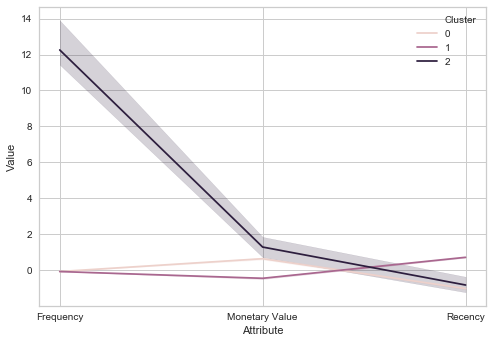

In [55]:
sb.lineplot('Attribute', 'Value', hue = 'Cluster', data = subscribers_melt)

### TODO: snakeplot segment interpretation